In [13]:
%matplotlib inline
import matplotlib as plt
import matplotlib.image as mpimg

import numpy as np
import joblib

In [16]:
class DLA():

    def __init__(self, size, k):
        self.size = size
        self.state = np.zeros((size, size), dtype = int)
        self.state[size / 2, size / 2] = 1
        
        self.xBounds = (size/2, size/2)
        self.yBounds = (size/2, size/2)
        
        self.radius = 0
        self.xcenter = size/2
        self.ycenter = size/2
        
        self.k = k
        
    def printState(self):
        '''
            Uses matplotlib to display current image inline
        '''
        plt.pyplot.imshow(1 - self.state, cmap='gray')
    
    def writeState(self, fileName):
        '''
            Dumps np matrix to fileName
        '''
        with open(fileName, 'w') as fp:
            joblib.dump(self.state, fp)
            
    def loadState(self, fileName):
        '''
            Loads np matrix from fileName
        '''
        with open(fileName, 'r') as fp:
            self.state = joblib.load(fp)
            
    def getSeed(self):
        '''
            Returns a randomly sampled initial position
            for a particle. 
            Returns (x, y) tuple
        '''
        
        boundingCircle = self.getBoundingCircle()
        p = np.random.randint(len(boundingCircle))
        
        return boundingCircle[p]
    
    def isValid(self, curr):
        '''
            Checks wether (x, y) is in grid
            Returns True/False
        '''
        x, y = curr    
        return x > -1 and x < self.size and y > -1 and y < self.size
    
    def getAdjacentPoints(self, curr):
        '''
            Returns points adjacent to curr within image bounds
            Assumption : Adjacent includes diagonal neighbors (max 8)
                            A|A|A
                            A|X|A
                            A|A|A
                 
            Input args:
                curr : (x, y) tuple
            Returns:
                List of adjacent points
        '''
        
        x, y = curr
        adjacentPoints = [(x - 1, y - 1), (x - 1, y), (x - 1, y + 1),
                          (x, y - 1),                 (x, y + 1),
                          (x + 1, y - 1), (x + 1, y), (x + 1, y + 1)]
        
        # Remove points outside the image
        adjacentPoints = filter(lambda x : x[0] > -1 and x[0] < self.size and \
                                           x[1] > -1 and x[1] < self.size, adjacentPoints)
        return adjacentPoints
    
    
    def getBoundingCircle(self):
        '''
            Gets bounding circle of current image
            Returns list of points in bounding circle
        '''
        
        points = {}
        
        y1, y2 = self.ycenter, self.ycenter

        for x in range(self.xcenter - self.radius - 10, self.xcenter + 1):
            while (y1 - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius)**2:
                y1 -= 1
            k = y1
            while (k - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius + 1)**2:
                if self.isValid((x, k)):
                    points[(x, k)] = True
                k -= 1

            while (y2 - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius)**2:
                y2 += 1
            k = y2
            while (k - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius + 1)**2:
                if self.isValid((x, k)):
                    points[(x, k)] = True
                k += 1
            
        y1, y2 = self.ycenter, self.ycenter
        for x in range(self.xcenter + self.radius + 10, self.xcenter, -1):
            while (y1 - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius)**2:
                y1 -= 1
            k = y1
            while (k - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius + 1)**2:
                if self.isValid((x, k)):
                    points[(x, k)] = True
                k -= 1
                
            while (y2 - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius)**2:
                y2 += 1
            k = y2
            while (k - self.ycenter) ** 2 + (x - self.xcenter) ** 2 <= (self.radius + 1)**2:
                if self.isValid((x, k)):
                    points[(x, k)] = True
                k += 1
        
        if any(map(lambda x : self.state[x] == 1, points.keys())):
            print 'can spawn at marked'
        
        return points.keys()
        
    def checkIfTerminate(self, curr):
        '''
            Check if curr sticks in image.
            Will happen with prob k if any adjacent block is 1
     
            Input args:
                curr : (x, y) tuple
            Returns True/False
        '''
        adjacentPoints = self.getAdjacentPoints(curr)
        return any(map(lambda x : self.state[x] == 1, adjacentPoints)) and np.random.rand() < self.k
    
    def getNextPosition(self, curr):
        '''
            Get next point. Brownian motion is order 1 markov process
            
            Input args:
                curr : (x, y) tuple
            Returns:
                (x, y) coordinate of next position
        '''
        
        adjacentPoints = self.getAdjacentPoints(curr) # List of adjacent points
        adjacentPoints = filter(lambda x : self.state[x] == 0, adjacentPoints)
        s = np.random.randint(len(adjacentPoints))    # Get random point
        return adjacentPoints[s]

    def getSurfaceArea(self):
        '''
            Get surface area of all points. 
            Presently O(m**2), can be done better
            Returns integer
        '''
        
        area = 0
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i, j] == 1:
                    adj = self.getAdjacentPoints((i, j))
                    adj = filter(lambda x : self.state[x] == 0, adj)
                    area += len(adj)
        
        return area
    
    def getNeighbourCount(self):
        '''
            For each cell with 1, count neghbouring cells with 1
            Returns integer
        '''
        
        count = 0
        for i in range(self.size):
            for j in range(self.size):
                if self.state[i, j] == 1:
                    adj = self.getAdjacentPoints((i, j))
                    adj = filter(lambda x : self.state[x] == 1, adj)
                    count += len(adj)
        
        return count
    
    def addPoint(self, numPoints = 1):
        '''
            Adds a new particle to the matrix
        '''
        
        count = 0
        while count < numPoints:
            
            if (count + 1) % 100 == 0:
                print count

            curr = self.getSeed() # Get initial position
            
            while not self.checkIfTerminate(curr):
                curr = self.getNextPosition(curr)
                if (curr[0] - self.xcenter) ** 2 + (curr[1] - self.ycenter) ** 2 > (self.radius + 15) ** 2:
                    curr = self.getSeed() # Go back to random point in bounding circle
                    
            self.state[curr] = 1
            
            # Update bounds
            x, y = curr
            
            xmin, xmax = self.xBounds
            xmin = min(xmin, x)
            xmax = max(xmax, x)
            self.xBounds = (xmin, xmax)
            
            ymin, ymax = self.yBounds
            ymin = min(ymin, y)
            ymax = max(ymax, y)
            self.yBounds = (ymin, ymax)
            
            # Calculate new radius
            self.xcenter = (xmax + xmin) / 2
            self.ycenter = (ymax + ymin) / 2
            self.radius = int(((xmax - self.xcenter) ** 2 + (ymax - self.ycenter) **  2) ** 0.5) + 1

            count += 1
        

In [10]:
dla = DLA(500, 0.1)

In [11]:
dla.addPoint(6000)

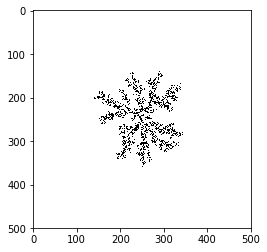

In [12]:
dla.printState()